# EnhancedPreprocessor

Here we demonstrate a class for tokenization and lemmatization that offers:

- Fairly fast tokenization and lemmatization.
- A stop word list designed for the tool's default output.
- The option to "lemmatize" the parts of an English contraction, e.g. turn *haven't* into the tokens *have* and *not*.
- The option of, during tokenization, not splitting digits which are separated only by punctuation, thus preserving IP addresses, telephone numbers and times of day.
- The ability to split or retain *'s* (apostrophe 's'), according to the user's requirements.
- The ability to deal with punctuation, stop words, and telephone numbers in one of three ways: treat them like any other input; remove them from the output completely; replace them with the dummy tokens '\_PUNC\_', '\_STOP\_' and '\_TEL\_'.
- Extensibility, so that users can treat other types of strings in the same manner as punctuation, stop words and telephone numbers. For example, you may want to identify URLs as such, rather than split them up into tokens split by punctuation..
- Acceptable, if not perfect, lemmatization of nouns and some verb forms.

**SimplePreprocessor**. If you do not need the bells and whistles, check out SimplePreprocessor, EnhancedPreprocessor's streamlined, and consequently faster, model. Because it offers the user few options, I was able to write the code to be more efficient. The two preprocessors use the same stop word list and NLTK WordNetLemmatizer. The [SimplePreprocessor notebook](./SimplePreprocessor.ipynb) has extensive notes on the stop word list, and describes some issues with the lemmatizer.

## Motivation

The EnhancedPreprocessor class is designed for use cases like the following.

**Text categorization.** 

Let's consider document preprocessing&mdash;that is, tokenization and lemmatization&mdash;for the use case of text categorization. Suppose that one class of documents in your corpus consists of many telephone numbers, and that another class has tables containing many other kinds of numbers.

Some tokenizers eliminate numbers completely. Others split telephone numbers by spaces or punctuation. So, for example, the (American-style) telephone number of *973-449-3636* will be split into three tokens: *973*, *449* and *3636*. And *(973)449-3636* might be tokenized in the same way, or the first number might be tokenized into *(973)*.

If your tokenizer behaves like either of these, you're going to have to hope that these two document types have some other distinguishing characteristic, or your categorization will fail.

Suppose also that after the first round of categorization you realized that your classifier might perform better if it could identify URLs as URLs rather than a series of separate tokens such as: https, forecast, weather, gov, MapClick, php, lat, =, 40, ., 7835, &, lon, =, -, 74, ., 4797, #, ., XLRcHy, -, ZOt9. You would have to rewrite your tokenizer. But it would be nice if the tokenizer you were already using had been designed for this kind of extensibility.

**N-grams**

Many tokenizers remove stop words. This is often useful, but it's not very good for research involving n-grams, since your n-grams will include words that, in your corpus, were separated by stop words. 

You could create a separate tokenizer for tasks involving n-grams, but it would be easier to use a tokenizer that offered options that would let it be used for n-grams with no extra work.

## EnhancedPreprocessor code

EnhancedPreprocessor offers a lot of functionality, and the code is consequently quite complex. In lieu of reading the code first thing, it might be better to "prime" yourself by going through the examples in the [Using the tokenizer](#usingthetokenizer) and the [Using the class](#usingtheclass) sections which follows.

### Stop word list

EnhancedPreprocessor and its sister class SimplePreprocessor share the same stop word list. The list can be re-generated at any time, which I believe helps avoid the too-frequent divergence of stop word lists and preprocessing functions which often seems to occur. See the [SimplePreprocessor notebook](./SimplePreprocessor.ipynb) for details.

In [1]:
from spacy.lang.en.stop_words import STOP_WORDS as SpacyStopWords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as SklearnStopWords

def generateStopWords():
    """
    Generate stopwords, following a pre-determined routine. 
    :return: a set of strings
    """
    # Start with intersection of Spacy and sklearn stop word lists.
    spacySet = set(SpacyStopWords)
    sklearnSet = set(SklearnStopWords)
    tempStopWords = spacySet.intersection(sklearnSet)

    # Add verb forms of common verbs which are not already in the list.
    forms = ['gets', 'getting', 'got', 'gotten',
             'goes', 'going', 'gone', 'went',
             'does', 'doing', 'did',
             'having',
             'make', 'makes', 'making',
             'takes', 'taking', 'took']
    tempStopWords = tempStopWords.union(forms)

    # Assume contractions are split on the apostrophe. Add the left- and right-hand sides.
    lefts = ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'shouldn',
             'wasn', 'weren', 'won', 'wouldn']
    rights = ['d', 'll', 'm', 're', 's', 't', 've']
    # Don't include colloquial contractions such as these: ain't, cause, gimme, gonna, gotta, y'all
    # Don't include relatively uncommon contractions such as these: daren't, mayn't, needn't, 'tis, 
    # 'twas
    contractions = lefts + rights
    tempStopWords = tempStopWords.union(contractions)

    # Remove from the list very uncommon words.
    uncommonWords = "elsewhere hence hereafter hereby herein hereupon latterly meanwhile thence thereafter "
    uncommonWords += "thereby therein thereupon whence whereafter whereas whereby wherein whereupon whither whom"
    uncommonWordSet = set(uncommonWords.split(' '))
    tempStopWords = tempStopWords - uncommonWordSet

    return tempStopWords

In [2]:
StopWords = generateStopWords()

### Tokenizer code

EnhancedPreprocessor's tokenization is performed by two functions: tokenize( ) and encodeDigitStrs( ). The former is the entry point, and it calls the latter.

If all you need is tokenization, tokenizer( ) can be called directly, without creating an EnhancedPreprocessor object.

In [3]:
import html
from enum import Enum
import regex as re
import unicodedata as ud

from nltk import WordNetLemmatizer

In [4]:
def encodeDigitStrs(inStr, prefix):
    """
    Encode the given strings digit sub-strings so that they won't be split during tokenization.
    :param inStr: a string, which may or may not contain digit sub-strings
    :param prefix: a string which would be very unlikely to be found in normal text, which
    will be inserted into the given string so that digit strings will not be tokenized
    :return: a string in which the digit sub-strings have been "encoded" so that
    they will not be tokenized
    """
    # Punctuation which is allowed to join strings of digits is given in
    # this part of the regex: "[,-.:]"
    digitStrRegex = r'(\d+(?:[,-.:]+\d+)*)'

    matchStrs = re.finditer(digitStrRegex, inStr)
    newStr = ''
    lastIdx = 0
    
    for matchStr in matchStrs:
        matchStrt = matchStr.regs[0][0]
        matchEnd = matchStr.regs[0][1]

        # Append from the end of the last match to the start of this one.
        newStr += inStr[lastIdx:matchStrt]

        # Append the contents of this match, modified.
        newMatch = inStr[matchStrt:matchEnd]
        # Replace the punctuation with words that won't be tokenized.
        newMatch = newMatch.replace(',', '_comma_')
        newMatch = newMatch.replace('-', '_hyphen_')
        newMatch = newMatch.replace('.', '_period_')
        newMatch = newMatch.replace(':', '_colon_')
        newStr += prefix + newMatch

        lastIdx = matchEnd
    # Append what remains.
    newStr += inStr[lastIdx:]

    return newStr


def tokenize(inputStr, bLowercase=True, bLemmatizeContractions=False, bPreserveApostropheS=False,
             bPreserveDigitStrings=False, minTokenLen=1):
    """
    Split a string into tokens.
    Offers special behavior if any of the parameters is set to a non-default
    value--but note that some of this behavior assumes that text coming in has been
    lowercased.
    See the __init__( ) method of CorpusPreprocessor for documentation on this
    function's parameters.
    :param inputStr:
    :param bLowercase:
    :param bLemmatizeContractions:
    :param bPreserveApostropheS:
    :param bPreserveDigitStrings:
    :param minTokenLen:
    :return:
    """
    inStr = html.unescape(inputStr)

    # We defer lowercasing until after tokenization in order to maximize the quality
    # of abbreviation tokenization.

    # Avoid splitting apostrophe "s" by first replacing the string with
    # something unlikely to occur in normal text.
    if bPreserveApostropheS:
        inStr = inStr.replace("'s", " apostrophe_s_qpwpqp")
        if bLowercase:
            inStr = inStr.replace("'s", " apostrophe_s_qpwpqp")
        else:
            inStr = inStr.replace("'S", " apostrophe_cap_s_qpwpqp")

    # Avoid splitting digit strings.
    digitStrPrefix = "digitStr_"
    if bPreserveDigitStrings:
        inStr = encodeDigitStrs(inStr, digitStrPrefix)

    if bLemmatizeContractions:
        inStr = inStr.replace("won't", "will not")
        inStr = inStr.replace("shan't", "shall not")
        inStr = inStr.replace("n't", " not")
        inStr = inStr.replace("'ve", " have")
        inStr = inStr.replace("'m", " am")
        inStr = inStr.replace("'re", " are")
        # We can't replace apostrophe 's' because there's no way to tell
        # whether it's a possessive or a contraction of "has".
        # inStr = inStr.replace("'s", " has")
        if bLowercase:
            inStr = inStr.replace("WON'T", "will not")
            inStr = inStr.replace("SHAN'T", "shall not")
            inStr = inStr.replace("N'T", " not")
            inStr = inStr.replace("'VE", " have")
            inStr = inStr.replace("'M", " am")
            inStr = inStr.replace("'RE", " are")
        else:
            inStr = inStr.replace("WON'T", "WILL NOT")
            inStr = inStr.replace("SHAN'T", "SHALL NOT")
            inStr = inStr.replace("N'T", " NOT")
            inStr = inStr.replace("'VE", " HAVE")
            inStr = inStr.replace("'M", " AM")
            inStr = inStr.replace("'RE", " ARE")

    # The second half of this regex captures all-punctuation strings
    # (i.e. not word character and not space).
    # tokens = re.findall(r'\w+|[^\w\s]+', inStr)
    tokens = re.findall(r'(?:[A-Z][a-z]?[a-z]?[a-z]?\.)+|(?:[a-z]\.)+|\w+|[^\w\s]+', inStr)

    # Decode the special tokens in a single pass.
    result = []
    for token in tokens:
        if bPreserveApostropheS:
            token = token.replace("apostrophe_s_qpwpqp", "'s")
            token = token.replace("apostrophe_cap_s_qpwpqp", "'S")
        if bPreserveDigitStrings and token.startswith(digitStrPrefix):
            token = token.replace(digitStrPrefix, '')
            token = token.replace('_comma_', ',')
            token = token.replace('_hyphen_', '-')
            token = token.replace('_period_', '.')
            token = token.replace('_colon_', ':')

        if len(token) < minTokenLen:
            continue

        if bLowercase:
            token = token.lower()

        result.append(token)

    return result


<a name="usingthetokenizer"></a>

### Using the tokenizer

Here we provide some sample input and output for the tokenizer.

#### bPreserveDigitStrings

With bPreserveDigitStrings turned off.

In [5]:
inputStr = "They called me at 800-989-9999 at 8:00, and at (973)436-7888 at noon. "
inputStr += "The first time they didn't know the IP address, and the second time they said "
inputStr += "it was 173.70.92.252."
outputTokens = tokenize(inputStr, bPreserveDigitStrings=False)
print(outputTokens)

['they', 'called', 'me', 'at', '800', '-', '989', '-', '9999', 'at', '8', ':', '00', ',', 'and', 'at', '(', '973', ')', '436', '-', '7888', 'at', 'noon', '.', 'the', 'first', 'time', 'they', 'didn', "'", 't', 'know', 'the', 'ip', 'address', ',', 'and', 'the', 'second', 'time', 'they', 'said', 'it', 'was', '173', '.', '70', '.', '92', '.', '252', '.']


With bPreserveDigitStrings turned on.

In [6]:
outputTokens = tokenize(inputStr, bPreserveDigitStrings=True)
print(outputTokens)

['they', 'called', 'me', 'at', '800-989-9999', 'at', '8:00', ',', 'and', 'at', '(', '973', ')', '436-7888', 'at', 'noon', '.', 'the', 'first', 'time', 'they', 'didn', "'", 't', 'know', 'the', 'ip', 'address', ',', 'and', 'the', 'second', 'time', 'they', 'said', 'it', 'was', '173.70.92.252', '.']


Notice how the bPreserveDigitStrings works for times, telephone numbers and IP addresses. It also preserves numbers like *1,000* and *54.67*.

#### bLemmatizeContractions and bPreserveApostropheS

With bLemmatizeContractions and bPreserveApostropheS turned off.

In [7]:
inputStr = "I'm sure that, since he's sick, John's family won't be attending."
outputTokens = tokenize(inputStr, bLemmatizeContractions=False)
print(outputTokens)

['i', "'", 'm', 'sure', 'that', ',', 'since', 'he', "'", 's', 'sick', ',', 'john', "'", 's', 'family', 'won', "'", 't', 'be', 'attending', '.']


With bLemmatizeContractions and bPreserveApostropheS turned on.

In [8]:
outputTokens = tokenize(inputStr, bLemmatizeContractions=True)
print(outputTokens)

['i', 'am', 'sure', 'that', ',', 'since', 'he', "'", 's', 'sick', ',', 'john', "'", 's', 'family', 'will', 'not', 'be', 'attending', '.']


Notice that tokenizer( ) doesn't "lemmatize" the contraction *he's* because it has no syntactic knowledge&mdash;it can't distinguish the contraction *'s* from the possessive *apostrophe s*.

### The HandlingOption enum

EnhancedPreprocessor has an enum called *HandlingOption*. Here's the file's documentation on this object.

```
# Certain items like punctuation can be deleted from the token list (removed),
# or rolled up into a dummy token (replaced), or treated normally.
HandlingOption = Enum('HandlingOption', ['Remove', 'Replace', 'Normal'])
```

The HandlingOption pertains to three types of strings: stop words, punctuation and telephone numbers. For each of these types, the user can decide how each one is to be handled.

Choosing HandlingOption.Replace for all three will replace each of these token types with their dummy tokens wherever they occur. The dummy tokens are defined in the class in this way:

```
STOP_DUMMY = '_STOP_'
PUNC_DUMMY = '_PUNC_'
TEL_DUMMY = '_TEL_'
```

### EnhancedPreprocessor code

In [9]:
# Certain items like punctuation can be deleted from the token list (removed),
# or rolled up into a dummy token (replaced), or treated normally.
HandlingOption = Enum('HandlingOption', ['Remove', 'Replace', 'Normal'])


class EnhancedPreprocessor(object):
    """"""

    telRegex = re.compile(r".*?(\(?(?:\d{3}\D{0,3})?\d{3}\D{0,3}\d{4}).*?", re.S)

    STOP_DUMMY = '_STOP_'
    PUNC_DUMMY = '_PUNC_'
    TEL_DUMMY = '_TEL_'

    lm = WordNetLemmatizer()

    def __init__(self, stopWordList=StopWords,
                 bLowercase=True,
                 bLemmatize=True,
                 bLemmatizeContractions=False,
                 bPreserveApostropheS=False,
                 bPreserveDigitStrings=False,
                 stopWords=HandlingOption.Remove,
                 punc=HandlingOption.Normal,
                 telNbrs=HandlingOption.Normal,
                 minTokenLen=2):

        """
        Set this object's options, which will be used when user calls process( )
        to tokenize and optionally lemmatize a piece of text. Note that some of
        these options assume that bLowercase is True.

        :param stopWordList: a lset of stop words; default is to use a set
        tailored specially for this class; NOTE: if using your own stop words,
        make sure it's a O(1) set rather than an O(n) list

        :param bLowercase: lowercase the input before doing any processing

        :param bLemmatize: use WordNetLemmatizer to lemmatize all words; note
        that, generally, this lemmatizer only operates on nouns and not the
        various verb forms

        :param bLemmatizeContractions: boolean; lemmatize contractions, e.g.
        tokenize "doesn't" as "does not"; if False function splits it into
        three: "does", "'" and "t"

        :param bPreserveApostropheS: boolean; preserve apostrophe 's', e.g.
        split "mark's" into "mark" and "'s"; if False, it is split into "mark",
        "'" and "s"

        :param bPreserveDigitStrings: boolean; preserve digit strings, i.e.
        strings composed of digits and certain punctuation characters; e.g. ip
        addresses and numbers like "1,000" and "8.5"; automatically set to True
        if telNbrs parameter is set to Replace or Remove

        :param stopWords: a member of HandlingOption; indicates how to handle
        stop words; options Replace and Remove assume input has been lowercased

        :param punc: a member of HandlingOption; indicates how to handle
        punctuation

        :param telNbrs: a member of HandlingOption; indicates how to handle
        telephone numbers; options Replace and Remove force
        bPreserveDigitStrings to be True

        :param minTokenLen: integer; the minimum number of characters a token
        may have--tokens shorter than this length will be filtered out
        """
        # Check input for the parameters which don't result in a clear error message when they
        # have invalid values.
        args = locals().copy()
        args.pop('self')
        # print(args)
        for arg in args.keys():
            value = args[arg]
            if arg == 'minTokenLen' or arg == 'stopWordList':
                pass
            elif arg.startswith('b'):
                if value not in [True, False]:
                    msg = "Value of parameter %s is '%s'. It must be boolean." % (arg, str(value))
                    raise ValueError(msg)
            elif not isinstance(value, HandlingOption):
                msg = "Value of parameter %s is '%s'. " % (arg, str(value))
                msg += "It must be a member of RollupOption with a value in %s. " \
                       % (str([x.name for x in list(HandlingOption)]))
                raise ValueError(msg)

        self.bLowercase = bLowercase
        self.bLemmatize = bLemmatize
        self.lemContractions = bLemmatizeContractions
        self.bPresApostropheS = bPreserveApostropheS
        self.bPresDigitStrings = bPreserveDigitStrings
        self.stopWords = stopWords
        self.punc = punc

        if telNbrs != HandlingOption.Normal:
            self.bPresDigitStrings = True
        self.telephoneNbrs = telNbrs

        self.stopWordList = stopWordList
        self.minTokenLen = minTokenLen
        
    def process(self, inStr):
        """
        Filter or replace tokens as indicated in initialization.
        :param inStr:
        :return:
        """
        # We defer lowercasing until after tokenization in order to maximize the quality
        # of abbreviation tokenization.

        tokens = tokenize(inStr, bLowercase=self.bLowercase,
                          bLemmatizeContractions=self.lemContractions,
                          bPreserveApostropheS=self.bPresApostropheS,
                          bPreserveDigitStrings=self.bPresDigitStrings,
                          minTokenLen=self.minTokenLen)

        result = []
        for token in tokens:

            # Test the parameters which are ternary. If Normal, do nothing special.
            # If Replace, append to result and continue. If Remove, just continue.
            if self.stopWords != HandlingOption.Normal:
                if token in self.stopWordList:
                    if self.stopWords == HandlingOption.Replace:
                        result.append(self.STOP_DUMMY)
                    continue

            # Lemmatize, if requested.
            if self.bLemmatize:
                issues = ['has', 'less', 'was']
                # Technically, the condition on the right below is redundant, since the only way
                # these three could have escaped stop word filtering is if we weren't
                # filtering stop words.
                if token in issues and self.stopWords == HandlingOption.Normal:
                    # These words are already in the correct lemma form.
                    pass
                else:
                    token = self.lm.lemmatize(token)

            if self.punc != HandlingOption.Normal:
                bAllPunc = True
                for char in token:
                    category = ud.category(char)
                    # P: punctuation; Sm: symbol math; Cc: control character
                    if category.startswith('P') or category == 'Sm' \
                            or category == 'Cc':
                        continue
                    bAllPunc = False
                    break

                if bAllPunc:
                    if self.punc == HandlingOption.Replace:
                        result.append(self.PUNC_DUMMY)
                    continue

            if self.telephoneNbrs != HandlingOption.Normal:
                if self.telRegex.search(token):
                    if self.telephoneNbrs == HandlingOption.Replace:
                        result.append(self.TEL_DUMMY)
                    continue

            result.append(token)

        return result


<a name="usingtheclass"></a>

### Using EnhancedPreprocessor

To use EnhancedPreprocessor, you declare the options you want when you create an instance of the class. Here's the parameter list for the __init__( ) method.

```
def __init__(self, stopWordList=StopWords.StopWords,
             bLowercase=True, 
             bLemmatize=True, 
             bLemmatizeContractions=False,
             bPreserveApostropheS=False, 
             bPreserveDigitStrings=False,
             stopWords=HandlingOption.Remove, 
             punc=HandlingOption.Normal, 
             telNbrs=HandlingOption.Normal,
             minTokenLen=2):
```

To make it easier to distinguish one parameter from another, those having boolean values are prefixed with the character 'b'.

Next we provide the documentation for some of the parameters used in this set of examples.

```
:param stopWords: a member of HandlingOption; indicates how to handle 
stop words; options Replace and Remove assume input has been lowercased

:param punc: a member of HandlingOption; indicates how to handle 
punctuation

:param telNbrs: a member of HandlingOption; indicates how to handle 
telephone numbers; options Replace and Remove force 
bPreserveDigitStrings to be True

:param minTokenLen: integer; the minimum number of characters a token 
may have--tokens shorter than this length will be filtered out
```

#### bPreserveDigitStrings and telNbrs 

With bPreserveDigitStrings turned on and telNbrs set to Replace.

In [10]:
preprocessor = EnhancedPreprocessor(bPreserveDigitStrings=True, 
                                               telNbrs=HandlingOption.Replace)
inputStr = "They called me at 800-989-9999 at 8:00, and at (973)436-7888 at noon. "
inputStr += "The first time they didn't know the IP address, and the second time they said "
inputStr += "it was 173.70.92.252."
outputTokens = preprocessor.process(inputStr)
print(outputTokens)

['called', '_TEL_', '8:00', '973', '_TEL_', 'noon', 'time', 'know', 'ip', 'address', 'second', 'time', 'said', '173.70.92.252']


Some things to note in the output above:
- Telephone number identification isn't perfect&mdash;the class fails to identify the entire string *(973)436-7888* as a telephone number.
- By default, stop words are removed and punctuation is not, though since the default value of `minTokenLen` is 1, single-character punctuation is removed.
- By default, the class lemmatizes. This example illustrates one of WordNetLemmatizer's failings&mdash;that verbs are not lemmatized (*said* is not lemmatized to *say*).
- It would be straightforward to extend the class to specially handle IP addresses. Simply mimick the way telephone numbers are handled, changing the regex to handle digits separated by periods.

#### stopWords and punc

This next example shows the application removing both stop words and punctuation.

In [11]:
preprocessor = EnhancedPreprocessor(stopWords=HandlingOption.Remove, 
                                               punc=HandlingOption.Remove)
inputStr = "They called me at 800-989-9999 at 8:00, and at (973)436-7888 at noon. "
inputStr += "The first time they didn't know the IP address, and the second time they said "
inputStr += "it was 173.70.92.252."
outputTokens = preprocessor.process(inputStr)
print(outputTokens)

['called', '800', '989', '9999', '00', '973', '436', '7888', 'noon', 'time', 'know', 'ip', 'address', 'second', 'time', 'said', '173', '70', '92', '252']


Compare that output to the following, with set to Replace. Note that the single-character punctuation would have been removed if we hadn't set `minTokenLen` to 1.

In [12]:
preprocessor = EnhancedPreprocessor(stopWords=HandlingOption.Replace, 
                                               punc=HandlingOption.Replace,
                                               minTokenLen=1)
inputStr = "They called me at 800-989-9999 at 8:00, and at (973)436-7888 at noon. "
inputStr += "The first time they didn't know the IP address, and the second time they said "
inputStr += "it was 173.70.92.252."
outputTokens = preprocessor.process(inputStr)
print(outputTokens)

['_STOP_', 'called', '_STOP_', '_STOP_', '800', '_PUNC_', '989', '_PUNC_', '9999', '_STOP_', '8', '_PUNC_', '00', '_PUNC_', '_STOP_', '_STOP_', '_PUNC_', '973', '_PUNC_', '436', '_PUNC_', '7888', '_STOP_', 'noon', '_PUNC_', '_STOP_', '_STOP_', 'time', '_STOP_', '_STOP_', '_PUNC_', '_STOP_', 'know', '_STOP_', 'ip', 'address', '_PUNC_', '_STOP_', '_STOP_', 'second', 'time', '_STOP_', 'said', '_STOP_', '_STOP_', '173', '_PUNC_', '70', '_PUNC_', '92', '_PUNC_', '252', '_PUNC_']


## Runtime notes

This section performs some runtime experiments meant to explore the following issues:
    - What is the runtime cost of using the EnhancedPreprocessor over the SimplePreprocessor for the same output?
    - What is the runtime cost of some of EnhancedPreprocessor's varioius options?

This notebook doesn't actually run the tests. Rather, it performs calculations on the test results. All the tests involved preprocessing a set of 2000 Imdb movie reviews.

### Test computers

Most of these tests were run on two machines, a fairly old Mac Workbook Pro, and a Dell PC Running Linux. In the code below, variables, etc. are likely to refer to these with the strings *BoxM* and *BoxL* respectively.

### Function for bar chart display

First we have to put in some code for the display of our results.

In [13]:
from statistics import mean

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
%matplotlib inline

def plot_bar_chart(title, runtimeDict, x_axis_range, x_axis_label):
    """
    title: string; title of bar chart
    runtimeDict: dictionary; keys are strings identifying each 
    bar in the chart and values are floats 
    x_axis_range: two-digit list where the first is less than the 
    second, e.g. (0, 20); range of x-axis
    x_axis_label: string; label of x-axis
    """
    plt.rcdefaults()
    # fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(5, 3))

    approaches = runtimeDict.keys()
    y_pos = np.arange(len(approaches))
    runtimes = np.asarray(list(runtimeDict.values()))

    # Set horizontal range here.
    ax.set_xlim(x_axis_range)
    ax.xaxis.set_major_locator(MaxNLocator(7))
    ax.xaxis.grid(True, linestyle='--', which='major',
                       color='grey', alpha=.25)

    rects = ax.barh(y_pos, runtimes, xerr=None, align='center', color='green')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(approaches)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(x_axis_label)
    ax.set_title(title)

    rect_labels = []
    # Lastly, write in the ranking inside each bar to aid in interpretation
    for idx, rect in enumerate(rects):
        # Rectangle widths are already integer-valued but are floating
        # type, so it helps to remove the trailing decimal point and 0 by
        # converting width to int type
        width = int(rect.get_width())

        rankStr = runtimes[idx]
        # The bars aren't wide enough to print the ranking inside
        if width < 5:
            # Shift the text to the right side of the right edge
            xloc = width + 1
            # Black against white background
            clr = 'black'
            align = 'left'
        else:
            # Shift the text to the left side of the right edge
            xloc = 0.98*width
            # White on magenta
            clr = 'white'
            align = 'right'

        # Center the text vertically in the bar
        yloc = rect.get_y() + rect.get_height()/2.0
        label = ax.text(xloc, yloc, rankStr, horizontalalignment=align,
                         verticalalignment='center', color=clr, weight='bold',
                         clip_on=True)
        rect_labels.append(label)

### EnhancedPreprocessor vs. SimplePreprocessor

[SimplePreprocessor](./SimplePreprocessor.ipnyb) is a slimmed-down version of EnhancedPreprocessor. SimplePreprocessor was created after I observed that the if-statements which EnhancedPreprocessor offers, and the for-loops which it requires, had a significant run-time cost. Therefore, in addition to tokenization, it allows only these options:

- lemmatization
- an adjustable minimum acceptable token length

So what is the "significant run=time cost" I refer to above? Here we compare runtimes for the two preprocessors using the default constructor of both. It's a fair comparison since the output for the two preprocessors using the default options is identical.

**For the Mac**

In [15]:
# SimplePreprocessor
simpleBoxM = [8.6, 8.5, 8.3]
simpleBoxMMean = round(mean(simpleBoxM), 2)
print("Box M SimplePreprocessor default options: %s" % round(simpleBoxMMean, 2))

# EnhancedPreprocessor
enhancedBoxM = [10.5, 10.3, 10.4]
enhancedBoxMMean = round(mean(enhancedBoxM), 2)
print("Box M EnhancedPreprocessor default options: %s" % round(enhancedBoxMMean, 2))

costBoxM = (simpleBoxMMean - enhancedBoxMMean) / simpleBoxMMean
print("\nBox M runtime cost of using EnhancedPreprocessor over SimplePreprocessor: %s" % round(costBoxM, 2))

Box M SimplePreprocessor default options: 8.47
Box M EnhancedPreprocessor default options: 10.4

Box M runtime cost of using EnhancedPreprocessor over SimplePreprocessor: -0.23


**For the Linux Machine**

In [16]:
# SimplePreprocessor
simpleBoxL = [4.3, 4.2, 4.3]
simpleBoxLMean = round(mean(simpleBoxL), 2)
print("Box L SimplePreprocessor default options: %s" % round(simpleBoxLMean, 2))

EnhancedPreprocessor
enhancedBoxL = [5.2, 5.2, 5.3]
enhancedBoxLMean = round(mean(enhancedBoxL), 2)
print("Box L EnhancedPreprocessor default options: %s" % round(enhancedBoxLMean, 2))

costBoxL = (simpleBoxLMean - enhancedBoxLMean) / simpleBoxLMean
print("\nBox L runtime cost of using EnhancedPreprocessor over SimplePreprocessor: %s" % round(costBoxM, 2))

Box L SimplePreprocessor default options: 4.27
Box L EnhancedPreprocessor default options: 5.23

Box L runtime cost of using EnhancedPreprocessor over SimplePreprocessor: -0.23


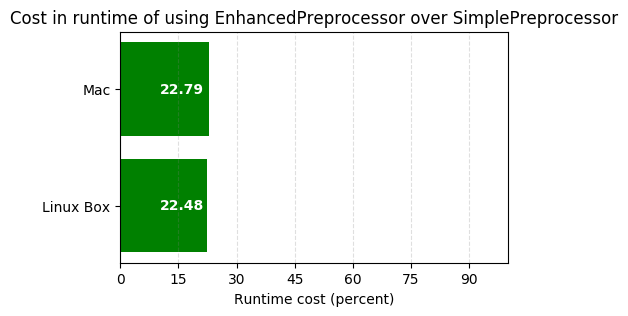

In [17]:
runtimeDict = {'Mac': round(-100 * costBoxM, 2), 'Linux Box': round(-100 * costBoxL, 2)}
plot_bar_chart('Cost in runtime of using EnhancedPreprocessor over SimplePreprocessor', 
             runtimeDict, 
             [0, 100],
            'Runtime cost (percent)')

# plt.show()

#### Conclusion

We see that, on both machines, it takes 22-23% longer to use the default version of the EnhancedPreprocessor as compared to the SimplePreprocessor.

### Cost comparison of various options



This set of runtime costs was performed only on the Mac, "Box M".

In [18]:
# EnhancedPreprocessor( )
defaultOptionsBoxM = [9.6, 9.6, 9.4, 9.3]
defaultOptionsBoxMMean = round(mean(defaultOptionsBoxM), 2)
print("Box M default options: %s" % round(defaultOptionsBoxMMean, 2))

# EnhancedPreprocessor(bPreserveDigitStrings=True)
preserveDigitStringsBoxM = [9.9, 10.0]
preserveDigitStringsBoxMMean = mean(preserveDigitStringsBoxM)
print("Box M bPreserveDigitStrings: %s" % round(preserveDigitStringsBoxMMean, 2))
preserveDigitStringsCostBoxM = \
    (defaultOptionsBoxMMean - preserveDigitStringsBoxMMean) / defaultOptionsBoxMMean

# EnhancedPreprocessor(bPreserveDigitStrings=True, 
#                                 telNbrs=HandlingOption.Replace)
telNbrsBoxM = [11.4, 11.3]
telNbrsBoxMMean = mean(telNbrsBoxM)
print("Box M replace telephone numbers: %s" % round(telNbrsBoxMMean, 2))
telNbrsCostBoxM = \
    (defaultOptionsBoxMMean - telNbrsBoxMMean) / defaultOptionsBoxMMean


# EnhancedPreprocessor(bLemmatizeContractions=True)
lemmaContractionsBoxM = [9.5, 9.5]
lemmaContractionsMean = mean(lemmaContractionsBoxM)
print("Box M lemmatizing contractions: %s" % round(lemmaContractionsMean, 2))
lemmaContractionsCostBoxM = \
    (defaultOptionsBoxMMean - lemmaContractionsMean) / defaultOptionsBoxMMean


# EnhancedPreprocessor(stopWords=HandlingOption.Replace, 
#                                  punc=HandlingOption.Replace)
replaceStopPuncBoxM = [10.6, 10.6]
replaceStopPuncBoxMMean = mean(replaceStopPuncBoxM)
print("Box M replace stop words and punc with dummies: %s" % round(replaceStopPuncBoxMMean, 2))
replaceStopPuncCostBoxM = \
    (defaultOptionsBoxMMean - replaceStopPuncBoxMMean) / defaultOptionsBoxMMean


Box M default options: 9.47
Box M bPreserveDigitStrings: 9.95
Box M replace telephone numbers: 11.35
Box M lemmatizing contractions: 9.5
Box M replace stop words and punc with dummies: 10.6


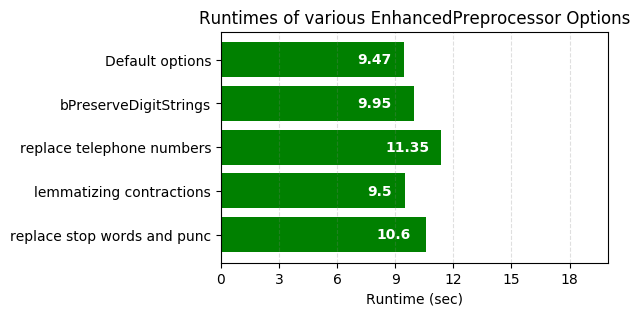

In [19]:
runtimeDict = {'Default options': round(defaultOptionsBoxMMean, 2), 
               'bPreserveDigitStrings': round(preserveDigitStringsBoxMMean, 2),
               'replace telephone numbers': round(telNbrsBoxMMean, 2),
               'lemmatizing contractions': round(lemmaContractionsMean, 2),
               'replace stop words and punc': round(replaceStopPuncBoxMMean, 2),}
plot_bar_chart('Runtimes of various EnhancedPreprocessor Options', 
             runtimeDict, 
             [0, 20],
            'Runtime (sec)')

# plt.show()

Now let's calculate the runtime costs.

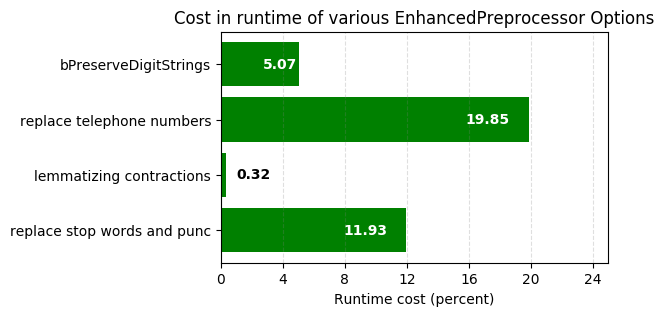

In [20]:
runtimeDict = {'bPreserveDigitStrings': round(-100 * preserveDigitStringsCostBoxM, 2),
               'replace telephone numbers': round(-100 * telNbrsCostBoxM, 2),
               'lemmatizing contractions': round(-100 * lemmaContractionsCostBoxM, 2),
               'replace stop words and punc': round(-100 * replaceStopPuncCostBoxM, 2),}
plot_bar_chart('Cost in runtime of various EnhancedPreprocessor Options', 
             runtimeDict, 
             [0, 25],
            'Runtime cost (percent)')

# plt.show()

#### Conclusion

The runtime costs of some of EnhancedPreprocessor's options can be very significant. If you don't need them, use SimplePreprocessor.

## Use of Python's __slots__

Recently I came across a blog describing the use of Python's `__slots__` to reduce the cost of accessing an object's attributes (aka properties). Since some of the difference in runtime between the Simple and the Enhanced preprocessors can be attributed to checking whether a particular option has been set by the user, I decided to explore whether the use of `__slots__` could make EnhancedPreprocessor run a little faster.

Rewriting the class was very easy. The only requirements are:

- The class must subclass `object`.
- All the object properties must be set in the constructor (the \_\_init\_\_( ) method).
- You declare the properties in the "static" section of the class. To borrow the example given by the second reference below:

```
class MyClass(object):
    __slots__ = ['name', 'identifier']
    def __init__(self, name, identifier):
        self.name = name
        self.identifier = identifier
```

References:
- [Stack Overflow's "Usage of __slots__?"](https://stackoverflow.com/questions/472000/usage-of-slots): a pretty detailed explanation which points out, as an aside, that users of the SqlAlchemy ORM can potentially see much benefit here
- [__slots__ Magic](http://book.pythontips.com/en/latest/__slots__magic.html): a quick introduction (which also makes the claim that PyPy implements `__slots__` optimization by default)
- [A quick dive into Python’s “__slots__”](https://blog.usejournal.com/a-quick-dive-into-pythons-slots-72cdc2d334e): but note that the author's examples fail to subclass `object`.


### Conclusion

Alas, testing did not show that a `__slots__` version of EnhancedPreprocessor ran any faster. To see the benefits, perhaps a class needs to access its properties more frequently than this one does.